In [2]:
# --- Setup: clone lab repo and enter it ---
!git clone https://github.com/dontolon/ml_beam_management_lab.git
%cd ml_beam_management_lab


Cloning into 'ml_beam_management_lab'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 24 (delta 4), reused 22 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 1.38 MiB | 3.79 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/home/dante/experiments/lab/notebooks/ml_beam_management_lab


/home/dante/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
%cd /home/dante/experiments/lab


/home/dante/experiments/lab


/home/dante/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [11]:
!pip install numpy>=1.22 pandas>=1.5 matplotlib>=3.6 torch>=2.0 scikit-learn>=1.2 utm>=0.7

In [86]:
import numpy as np
from pathlib import Path
from helper_scripts.load_data import normalize_pos, min_max
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

In [27]:
DATA_DIR = Path("data")

# Hard-coded base station (lat, lon)
BS_location = np.array([[33.42034722222222, -111.92915277777779]])

# UE Positions (lat, lon)
UE_locations = np.load(DATA_DIR / "scenario2_unit2_loc_1-2974.npy")[:, :2]

# Beam powers (linear scale)
beam_powers = np.load(DATA_DIR / "scenario2_unit1_pwr_60ghz_1-2974.npy")

print("BS_location:", BS_location.shape)
print("UE_locations:", UE_locations.shape)
print("beam_powers:", beam_powers.shape)

BS_location: (1, 2)
UE_locations: (2974, 2)
beam_powers: (2974, 64)


In [42]:
# Stack BS and UEs together
all_positions = np.vstack([BS_location, UE_locations])  # (1+N, 2)

# Min-max normalize everything
all_norm = min_max(all_positions, axis=0)

# First row is BS, rest are UEs
BS_norm = all_norm[0:1]
UE_norm = all_norm[1:]

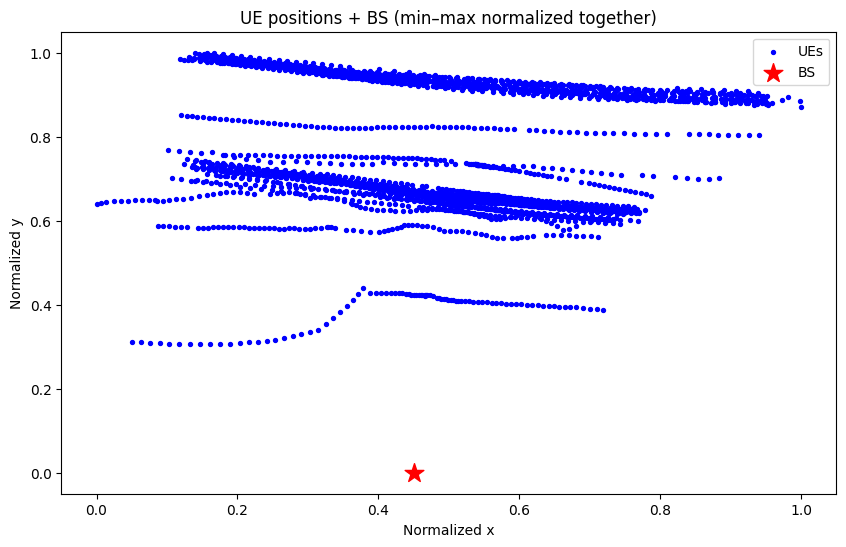

In [100]:
plt.figure(figsize=(10,6))
plt.scatter(UE_norm[:,0], UE_norm[:,1], c="blue", s=8, label="UEs")
plt.scatter(BS_norm[0,0], BS_norm[0,1], c="red", marker="*", s=200, label="BS")
plt.xlabel("Normalized x")
plt.ylabel("Normalized y")
plt.title("UE positions + BS (min–max normalized together)")
plt.legend()
plt.show()


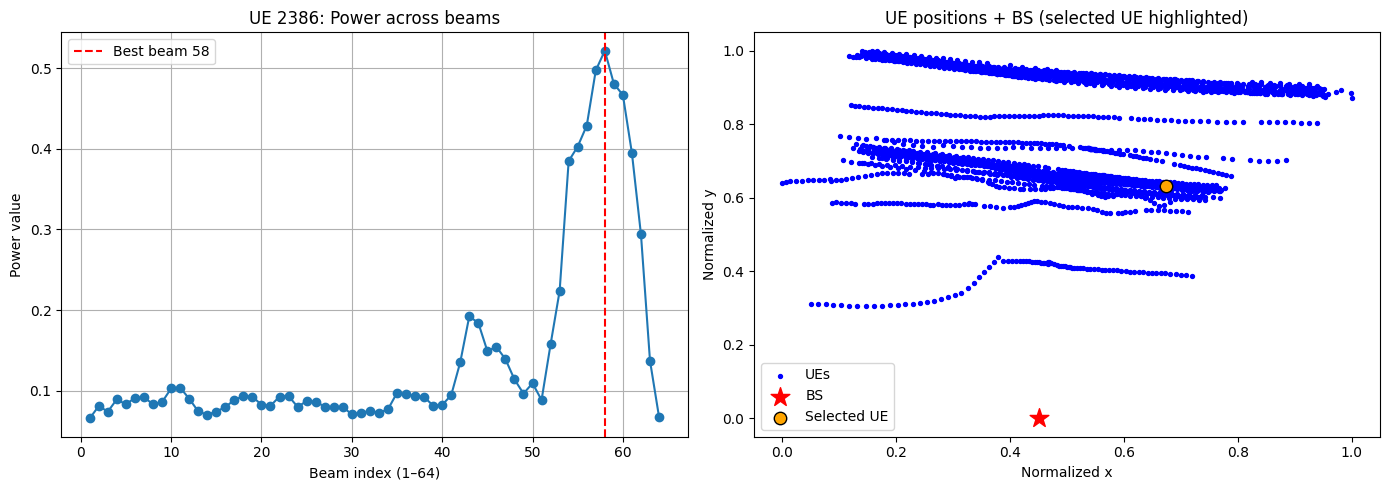

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Pick a random UE
idx = np.random.randint(0, beam_powers.shape[0])
powers = beam_powers[idx]
best_idx = np.argmax(powers)

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Left: beam power profile ---
axes[0].plot(range(1, len(powers)+1), powers, marker="o")
axes[0].axvline(best_idx+1, color="red", linestyle="--", label=f"Best beam {best_idx+1}")
axes[0].set_xlabel("Beam index (1–64)")
axes[0].set_ylabel("Power value")
axes[0].set_title(f"UE {idx}: Power across beams")
axes[0].legend()
axes[0].grid(True)

# --- Right: spatial scatter ---
axes[1].scatter(UE_norm[:,0], UE_norm[:,1], c="blue", s=8, label="UEs")
axes[1].scatter(BS_norm[0,0], BS_norm[0,1], c="red", marker="*", s=200, label="BS")
axes[1].scatter(UE_norm[idx,0], UE_norm[idx,1], c="orange", edgecolor="black", s=80, label="Selected UE")
axes[1].set_xlabel("Normalized x")
axes[1].set_ylabel("Normalized y")
axes[1].set_title("UE positions + BS (selected UE highlighted)")
axes[1].legend()

plt.tight_layout()
plt.show()


In [37]:
best_beam = np.argmax(beam_powers, axis=1)
X = UE_norm      # shape (N,2)
y = best_beam    # shape (N,)

print("Dataset created:")
print("X:", X.shape, "y:", y.shape)


Dataset created:
X: (2974, 2) y: (2974,)


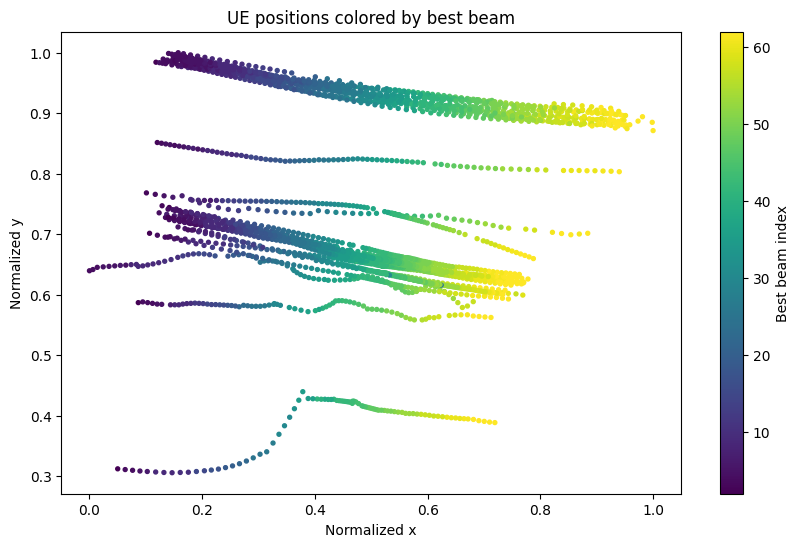

In [99]:
plt.figure(figsize=(10,6))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap="viridis", s=8)
plt.colorbar(sc, label="Best beam index")
plt.xlabel("Normalized x")
plt.ylabel("Normalized y")
plt.title("UE positions colored by best beam")
plt.show()


In [79]:
# Features are the normalized UE positions
X = UE_norm    # shape (N, 2)
print("Feature matrix shape:", X.shape)


Feature matrix shape: (2974, 2)


In [82]:
y = best_beam  # shape (N,)
print("label matrix shape:", y.shape)

label matrix shape: (2974,)


In [ ]:
# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Bundle into a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Create a DataLoader (mini-batches)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

print("Dataset ready for NN training!")
print("Number of batches:", len(loader))


Dataset ready for NN training!
Number of batches: 24


In [88]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# 70/30 split first
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Then split 30 into 15/15
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

# Convert to PyTorch tensors
def make_loader(X, y, batch_size=32, shuffle=False):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, batch_size=32, shuffle=True)
val_loader   = make_loader(X_val,   y_val,   batch_size=32)
test_loader  = make_loader(X_test,  y_test,  batch_size=32)


Train: (2081, 2) (2081,)
Val:   (446, 2) (446,)
Test:  (447, 2) (447,)


In [93]:
import torch.nn as nn

class BeamNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=256, hidden_layers=3, output_dim=64):
        super().__init__()
        layers = []
        in_dim = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = BeamNN(input_dim=2, hidden_dim=256, hidden_layers=3, output_dim=64)
print(model)


BeamNN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
  )
)


In [94]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Scheduler: reduce LR by factor 0.2 at epochs 20 and 40
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.2)


In [95]:
def run_epoch(loader, train=True):
    losses, correct, total = [], 0, 0
    if train: model.train()
    else: model.eval()

    for xb, yb in loader:
        if train: optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += len(yb)
    return np.mean(losses), correct/total

EPOCHS = 60
train_hist, val_hist = [], []

def evaluate(loader, model, k_values=[1,3,5,10]):
    """
    Evaluate top-k accuracies.
    Returns dict {k: acc}.
    """
    model.eval()
    correct_topk = {k: 0 for k in k_values}
    total = 0

    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb)                       # logits
            _, pred_topk = out.topk(max(k_values), dim=1)  # top-k predictions
            total += yb.size(0)
            for k in k_values:
                correct_topk[k] += (pred_topk[:, :k] == yb.unsqueeze(1)).any(dim=1).sum().item()

    return {k: correct_topk[k]/total for k in k_values}


for epoch in range(EPOCHS):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_metrics = evaluate(val_loader, model, k_values=[1,3,5,10])
    scheduler.step()

    train_hist.append((tr_loss, tr_acc))
    val_hist.append(val_metrics)

    if (epoch+1) % 10 == 0 or epoch < 5:
        print(f"Epoch {epoch+1:02d}: Train acc {tr_acc:.3f}, "
              f"Val top-1 {val_metrics[1]:.3f}, top-3 {val_metrics[3]:.3f}, "
              f"top-5 {val_metrics[5]:.3f}, top-10 {val_metrics[10]:.3f}")



Epoch 01: Train acc 0.148, Val top-1 0.179, top-3 0.435, top-5 0.594, top-10 0.812
Epoch 02: Train acc 0.226, Val top-1 0.159, top-3 0.531, top-5 0.686, top-10 0.892
Epoch 03: Train acc 0.302, Val top-1 0.179, top-3 0.594, top-5 0.776, top-10 0.930
Epoch 04: Train acc 0.321, Val top-1 0.258, top-3 0.556, top-5 0.682, top-10 0.895
Epoch 05: Train acc 0.342, Val top-1 0.343, top-3 0.603, top-5 0.834, top-10 0.962
Epoch 10: Train acc 0.398, Val top-1 0.285, top-3 0.679, top-5 0.870, top-10 0.989
Epoch 20: Train acc 0.411, Val top-1 0.388, top-3 0.740, top-5 0.906, top-10 0.996
Epoch 30: Train acc 0.486, Val top-1 0.482, top-3 0.821, top-5 0.944, top-10 0.993
Epoch 40: Train acc 0.469, Val top-1 0.507, top-3 0.827, top-5 0.944, top-10 0.996
Epoch 50: Train acc 0.506, Val top-1 0.518, top-3 0.834, top-5 0.957, top-10 0.996
Epoch 60: Train acc 0.506, Val top-1 0.522, top-3 0.827, top-5 0.951, top-10 0.996


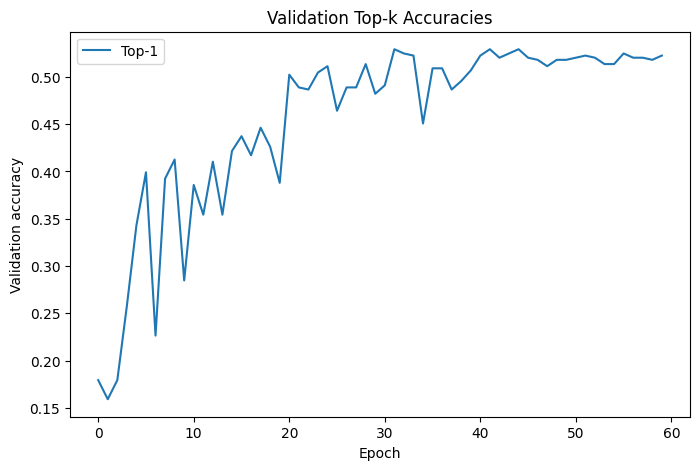

In [97]:
plt.figure(figsize=(8,5))
plt.plot([v[1] for v in val_hist], label="Top-1")
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation Top-k Accuracies")
plt.legend()
plt.show()
